# Chapter 1

This follows Causal Inference in Statistics, [Chapter 1](http://bayes.cs.ucla.edu/PRIMER/primer-ch1.pdf)

## $\S$ 1.2 Simpson's Paradox and Lord's Paradox

These are both paradoxes that take into account the idea of reversal. 

**Simpson's Paradox** deals with the selecting the better out of discrete options. The paradox, or reversal, occurs when choosing to stratify on a feature and find option 1 is better for every strata, but when considering the population as a whole, option 2 is better. The simple question "which is better" depends on whether you stratify or not.

The typical example of this is if Drug A does better for Men, and Drug A does better for Women, but when we look at the population as a whole, Drug B does better. This seems nonsensical, because if we know a person's gender we would recommend Drug A (regardless of which gender they have), but if we didn't, we would recommend Drug B.

An example of the paradox is 

| Sex        | Drug A recoveries | Drug B  recoveries |  Total |
| ---------- | ----------------- | ------------------ | ------ |
| **Male**   | 74 out of 80 (93%)| 234 out of 270 (87%)| 350   |
| **Female** | 193 out of 270 (71%)| 54 out of 80 (68%)| 350 | 
| **Total**  | 267 out of 350 (76%)| 288 out of 350 (82%)| 700 |  

We can see in this example, Drug A performs better for both Males an Females, but when combined, Drug B performs better. So what should our recommendation be?

Pearl claims that we need to know the data generation process to answer this question, and we cannot answer it from the table alone. One thing we _can_ do with the table above is give an understanding of how it happens mathematically. It is a consequence of weighted averages:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

example_1 = pd.DataFrame([{'sex': 'male', 'drug': 'A', 'success': 74, 'trials': 80},
                          {'sex': 'male', 'drug': 'B', 'success': 234, 'trials': 270},
                          {'sex': 'female', 'drug': 'A', 'success': 193, 'trials': 270},
                          {'sex': 'female', 'drug': 'B', 'success': 54, 'trials': 80}])
example_1

,sex,drug,success,trials
0,male,A,74,80
1,male,B,234,270
2,female,A,193,270
3,female,B,54,80


In [2]:
totals = example_1.groupby('drug', as_index=False).sum()
totals['sex'] = 'combined'
example_1 = pd.concat([example_1, totals])
example_1

,sex,drug,success,trials
0,male,A,74,80
1,male,B,234,270
2,female,A,193,270
3,female,B,54,80
0,combined,A,267,350
1,combined,B,288,350


We can also pivot it to see it in a way more similar to the original presentation:

In [3]:
example_1['rate'] = example_1['success'] / example_1['trials']
example_1.pivot(index='sex', columns='drug').style.format({
    ('rate', 'A'): '{:.1%}',
    ('rate', 'B'): '{:.1%}'
})

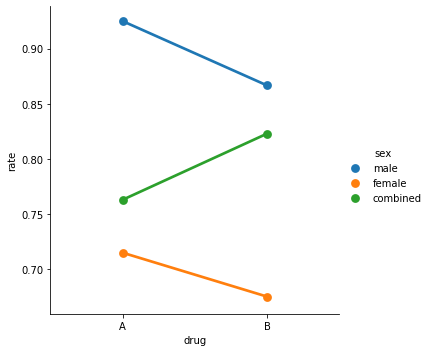

In [4]:
sns.catplot(x="drug", y="rate", hue='sex', kind="point", s='trials', data=example_1)

Both sexes perform better on Drug A, but women are more seriously affected by this disease (or, at least, are less likely to recover). The weighted average (green line) is skewed because Drug A had more women than men, which moves the average toward the female recovery rate. We are tempted to conclude that using the more specific information is correct (i.e. Drug A, better for Males or Females, should be used)


Pearl warns increasing the level of stratification isn't always the right thing to do. He gives the following example on blood pressure. 
- A drug lowers blood pressure of those that take it, but also has a toxic side-effect
- Lower blood pressure lowers the severity/risk of the disease.

We can have the _same_ values this time, but with different labels

| Post-treatment BP        | Placebo recoveries | Drug recoveries |  Total |
| ---------- | ----------------- | ------------------ | ------ |
| **Low BP**   | 74 out of 80 (93%)| 234 out of 270 (87%)| 350   |
| **High BP** | 193 out of 270 (71%)| 54 out of 80 (68%)| 350 | 
| **Total**  | 267 out of 350 (76%)| 288 out of 350 (82%)| 700 |  

The argument goes that this time we _shouldn't_ stratify on BP, even though last time we did stratify on Gender. 

Stratifying on blood pressure and selecting only those with _low_ blood pressure would leave us only with those that have been treated effectively (note that the bulk of patients that recieved the drug ended up with low BP after the trial). Once controlling for blood pressure, the only effect left to find would be the (negative) side effects.

If the blood pressure's were the _incoming_ BP (i.e. not affected by the drug), then we would treat them as similar to gender -- we just didn't stratify BP or gender in the different experiment, and our results were a consequence of having different weights in different treatments. Because it is the _post-treatment_ BP we are looking at, which is an effect of the drug, we shouldn't stratify on it.

Pearl's basic conclusion, that we can take the same table of numbers and change the labels -- even as minor as _when_ the BP recorded -- and reach opposite conclusions leads him to state there is no statistical test that we can use to determine the right approach. Instead, we need a causal model of the world to tell what the right analysis pattern should be.

**Lord's paradox** is a similar problem, but instead of choosing between discrete options, we are looking at the sign of a correlation between variables. If a correlation between $X$ and $Y$ appears with one sign when controlling for some variables, but reverses sign when controlling for a different set, this is an example of Lord's paradox.

A typical example is between Cholestorol and Exercise

In [5]:
N = 1300
age = np.random.normal(loc=30, scale=5, size=N).clip(18, 45)
exercise_weekly_hours = age + np.random.normal(scale=(age-16)*(46-age)/220, size=N)
cholesterol = age - 0.6*exercise_weekly_hours

In [6]:
example_2 = pd.DataFrame(dict(age=age, exercise=exercise_weekly_hours,cholesterol=cholesterol))

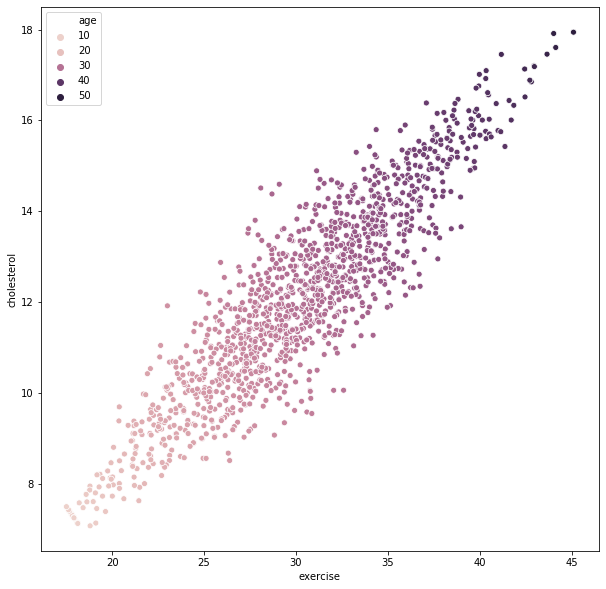

In [7]:
plt.figure(figsize=(10,10))

sns.scatterplot('exercise', 'cholesterol', hue='age',data=example_2);

Technically, blood pressure should be on a continuum as well. In this case, we can see if we don't look at the ages, there is a positive correlation between exercise and cholesterol. The different ages are hard to see on this palette, so let's discretize by five year intervals:

In [8]:
example_2['discrete_age'] = pd.cut(example_2.age, bins=np.arange(0, 100, 5))

In [9]:
example_2.head()

,age,exercise,cholesterol,discrete_age
0,39.347657,39.498500,15.648557,"(35, 40]"
1,39.274030,39.770171,15.411927,"(35, 40]"
2,28.607766,28.860765,11.291307,"(25, 30]"
3,32.565663,32.230489,13.227369,"(30, 35]"
4,33.511635,34.677430,12.705178,"(30, 35]"


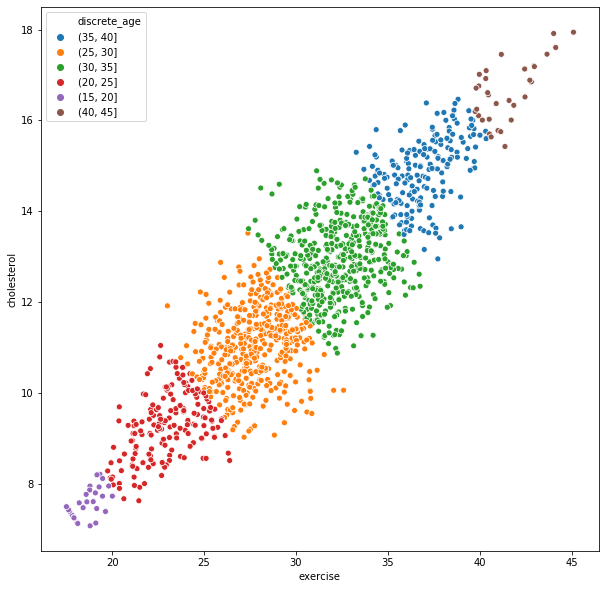

In [10]:
plt.figure(figsize=(10,10))

sns.scatterplot('exercise', 'cholesterol', hue='discrete_age',data=example_2);

Within each age bin, we see a _negative_ correlation between cholesterol and age, even though an age agnostic analysis shows a positive correlation.

We can see this directly, without discretizing age:

In [11]:
from sklearn.linear_model import LinearRegression

overall_lr = LinearRegression().fit(example_2[['exercise']], example_2['cholesterol'])
print(f"""
If we don't control for anything, the coefficient between exercise and cholesterol is {overall_lr.coef_[0]:3f}
""")


If we don't control for anything, the coefficient between exercise and cholesterol is 0.371462



Controlling for age:

In [12]:
overall_lr = LinearRegression().fit(example_2[['exercise', 'age']], example_2['cholesterol'])
equation_terms = [f'{coef:0.3f}*{name}' for coef, name in zip(overall_lr.coef_, ['exercise', 'age'])]
print(f"""
If we do control for age, the coefficient between exercise and cholesterol is {overall_lr.coef_[0]}. Equation is

cholesterol = {' + '.join(equation_terms)} + {overall_lr.intercept_}
""")


If we do control for age, the coefficient between exercise and cholesterol is -0.6000000000000006. Equation is

cholesterol = -0.600*exercise + 1.000*age + -5.329070518200751e-15



## With DAGs

In [13]:
%%javascript
require.config({
    paths: { 
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [14]:
from IPython.display import display, Javascript, HTML
import json

# This is needed to load d3
display(HTML(filename='tree.css.html'));
display(Javascript(filename="tree.js"))

<IPython.core.display.Javascript object>

In [15]:
def draw_network(data, width=600, height=400):
    """Uses D3 to draw a graph
    
    Parameters:
    data: List of Lists
          Each list contains links of the form [parent_node_label, child_node_label]
          
    Is unable to draw nodes not connected to any other edges
    """
    display(Javascript("""
        (function(element){
            require(['tree'], function(tree) {
                tree(element.get(0), %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), width, height)))
    

def draw_dag(parents_to_children, width=600, height=400):
    """Draws a DAG
    
    Parameters:
    parents_to_children: Dictionary
                         Keys are nodes, values are a list of children
    """
    network_data = []
    for parent, children in parents_to_children.items():
        links = [[parent, child] for child in children]
        network_data.extend(links)
    draw_network(network_data, width, height)

Part of what we want to be able to do is tell what we should control on, versus what we shouldn't, when doing our analysis. Let's go back to Drug A and Drug B vs gender.

Our "story" in this case was that women were more severely affected by this disease than men. Whether we give someone the drug or not doesn't influence their sex, but their sex did influence the recovery rate (regardless of whether the person took A or B). In terms of a causal story, we have

In [16]:
draw_dag({'gender': ['recovery'], 'drug': ['recovery']})

<IPython.core.display.Javascript object>

Let's contrast this with the blood pressure (drug vs placebo).

The drug had an effect on recovery through two mechanisms:
- it had a (negative) effect on health, though the side effects
- it lowered blood pressure, and lower blood pressure leads to better outcomes against the condition

In [17]:
draw_dag({'post_BP': ['recovery'], 'drug': ['recovery', 'post_BP']})

<IPython.core.display.Javascript object>

Here the blood pressure is a _mediator_ of (part) of the effect of the drug. If we control for BP, we are 'blocking' the information flowing along this path. To see this, by controlling/regressing on BP, we are saying we don't care _how_ the BP got its value (through the drug or natural variation). By not controlling for it, we are allowing ourselves to pick up the effect the drug choice can have _through_ the blood pressure.

If we wanted to isolate the side-effects, however, we could control for the blood pressure. This means that we are effectively "severing" the ties _into_ BP because we are taking it's value independently, so we are modeling the DAG.

In [18]:
# if we control for BP, we lose the information about _how_ BP gets it's value
draw_dag({'post_BP': ['recovery'], 'drug': ['recovery']})

<IPython.core.display.Javascript object>

The link from the drug to the recovery that _doesn't_ go through blood pressure is called the direct effect of the drug on the response.

**Note:** I do find the term "direct effect" troubling. Presumably the drug affects "recovery" through a bunch of other mechanisms (e.g. alter brain chemistry, altering acid reflux, ....) that ultimately influence recovery somehow. Claiming one thing is a direct effect on another, rather than through some mechanism that I haven't considered (or just haven't written down) seems like a fool's errand. I prefer to think of "direct effect" as "either direct or via some mechanism I am not considering"

In [19]:
# When I see direct effect, I am agnostic between that and mediation through some unknown
# and uncontrolled mechanisms
draw_dag({'post_BP': ['recovery'], 'drug': ['U1' ,'U2', 'U3', 'post_BP'], 
          'U1':['recovery'], 'U2':['recovery'], 'U3':['recovery']})

<IPython.core.display.Javascript object>

### The gender example revisited

In our gender example, we saw that a large proportion of women got drug A (and this caused Simpson's reversal). Was this random, or did the trial design actual encode this gender bias?

It is common for people with the most severe symptoms to get the "best" treatment. For example, those with the most severe COVID-19 cases will be the ones placed on the ventilators. So it is possible that Drug A, being the promising new drug, was disproportionately given to women, as they were the more vunerable population for this drug. So while the drug treatment didn't cause sex, sex can influence the drug administered (by the design of the study)

If the study was designed this way, would we change our conclusions?

In [20]:
draw_dag({'sex': ['drug', 'recovery'], 'drug': ['recovery']})

<IPython.core.display.Javascript object>

Our rule is 
> if we control for something, we have to eliminate all incoming arrows 

We are modeling it directly, we no longer care _how_ it obtained its value. In the example above, there are no arrows going into `sex`, so there is nothing to eliminate.

We are going to control for the drug taken (this is what we are going to measure), so in terms of our analysis, the effect is to eliminate all arrows going into `drug`. Controlling for `sex` and `drug` gives us the effective DAG

In [21]:
draw_dag({'sex':['recovery'], 'drug': ['recovery']})

<IPython.core.display.Javascript object>

i.e. the DAG that we started with, so it doesn't matter if `sex` influenced the `drug` policy. By controlling for both `sex` and `drug` we can estimate the effect of both, and "subtract off" the effect of `sex` to isolate the effect of the drug.

What happens if we didn't control for `sex`? 

In that case, we would not be able to estimate the weight of the arrow of `sex` to `recovery`. Since, in our model, we are assuming that sex does play a role in the effectiveness of recovery, we are not able to subtract off its effect from the effect of the drug.

## Where to from here?

* Look at salary example from [first_dag.ipynb]
* Look at $\S$ 1.5 on probability factorization
* Other examples / discussion?